# HomeSite Quote Conversion A Fastai Tabular Approach
> We used Fastai Tabular libary and WalkWithFastai functions to build our Deep Learning model for HomeSite Quote Conversion competition in Kaggle. The techniques used in this notebook include Permutation Importance Analysis, Model Ensembling, Bayesian Optimisation for hyperparameter tuning and Entity Embddings.

- toc: true to apply his techniques for permutation importance and ensemble learning to the Homesite Competition problem set
- badges: true
- comments: true
- categories: [kaggle, fastai]
- author: Nissan Dookeran and Tracy Dinh
- image: images/chart-preview.png

## Setup

In [ ]:
!pip install -Uqq fastai fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 194kB 14.5MB/s 
     |████████████████████████████████| 727kB 27.0MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 1.2MB 49.6MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 


In [ ]:
from fastai.tabular.all import *
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.metrics import roc_auc_score


## Download Data

Download your Kaggle KPI, store it in a folder in Google Drive and run the below codes

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Assign the folder where to want to store the data to path

In [ ]:
path = Path('/content/gdrive/MyDrive/Kaggle/' + 'data/homesite-quote')
path.mkdir(parents=True, exist_ok=True)
path

Path('/content/gdrive/MyDrive/Kaggle/data/homesite-quote')

Download your data into that folder

In [ ]:
!kaggle competitions download -c homesite-quote-conversion -p /content/gdrive/MyDrive/Kaggle/data/homesite-quote


Unzip your data

In [ ]:
! unzip -q -n '{path}/train.csv.zip' -d '{path}'
! unzip -q -n '{path}/test.csv.zip' -d '{path}'


Import data and store it as a dataframe 

In [ ]:
df = pd.read_csv(path/'train.csv', low_memory=False, parse_dates=['Original_Quote_Date'])
test_df=pd.read_csv(path/'test.csv', low_memory=False, parse_dates=['Original_Quote_Date'])

## EDA

In [ ]:
df_train = df.copy()
df_test = test_df.copy()


In [ ]:
df_train.QuoteConversion_Flag = df_train.QuoteConversion_Flag.astype(dtype='boolean')

In [ ]:
df_train = df_train.set_index('QuoteNumber')
df_test = df_test.set_index('QuoteNumber')


In [ ]:
df_train = add_datepart(df_train, 'Original_Quote_Date')
df_test = add_datepart(df_test, 'Original_Quote_Date')

In [ ]:
y_names = 'QuoteConversion_Flag'
cont_names, cat_names = cont_cat_split(df_train, dep_var=y_names)
len(cont_names), len(cat_names)

(155, 154)

## Deep Learning Model

Set up hyperparameters

In [ ]:
random_seed = 42 
bs = 4096
val_bs = 512
test_size = 0.3
epochs = 5
lr = 1e-2
wd=0.002
layers = [10000,500]
dropout = [0.001, 0.01]
y_block=CategoryBlock()
emb_dropout=0.02
set_seed(42)
roc_auc_binary = RocAucBinary()

In [ ]:
procs = [Categorify, FillMissing, Normalize]
splits = TrainTestSplitter(test_size=test_size, stratify=df_train[y_names])(df_train)

In [ ]:
to = TabularPandas(df=df_train, procs=procs, cat_names=cat_names, 
                   cont_names=cont_names, y_names=y_names,splits=splits,
                  y_block=y_block)
dls = to.dataloaders(bs=bs, val_bs=val_bs, layers=layers, embed_ps=emb_dropout, ps=dropout)
dls.valid.show_batch()

,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField2A,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,Original_Quote_Year,Original_Quote_Month,Original_Quote_Dayofweek,Original_Quote_Is_month_end,Original_Quote_Is_month_start,Original_Quote_Is_quarter_end,Original_Quote_Is_quarter_start,Original_Quote_Is_year_end,Original_Quote_Is_year_start,PersonalField84_na,PropertyField29_na,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField8,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField29,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21B,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField2

In [ ]:
learn = tabular_learner(dls, metrics=roc_auc_binary)

SuggestedLRs(valley=tensor(0.0006), slide=tensor(0.0158), minimum=0.05011872053146362, steep=0.05011872202157974)

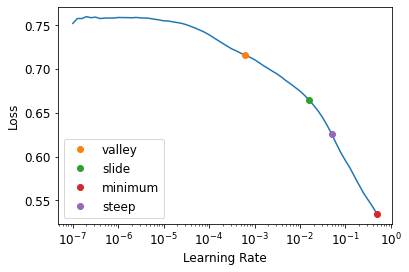

In [ ]:
learn.lr_find(start_lr=1e-07, end_lr=1000,suggest_funcs=(valley, slide, minimum, steep))

In [ ]:
learn.fit_one_cycle(epochs,lr, wd=wd)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.456341,0.247990,0.941812,00:06
1,0.267133,0.186897,0.959354,00:05
2,0.210462,0.183059,0.959837,00:06
3,0.185436,0.177092,0.962110,00:06
4,0.171974,0.176068,0.962788,00:06


In [ ]:
preds, targs = learn.get_preds()


In [ ]:
dl_roc_auc_score=roc_auc_score(to_np(targs), to_np(preds[:,1]))

## DL Permutation Importance

In [ ]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df if df is not None else None
    bs = bs if bs is not None else learn.dls.bs
    self.dl = learn.dls.test_dl(self.df, bs=bs) if self.df is not None else learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=30, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

Getting base error


Calculating Permutation Importance


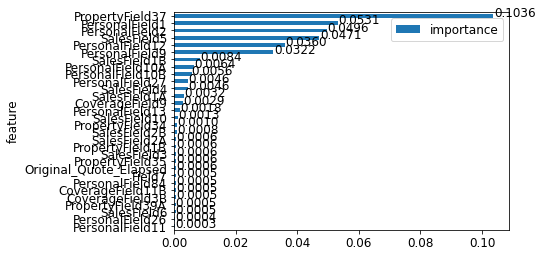

In [ ]:
imp = PermutationImportance(learn)

From this most important fields are `PropertyField37`, `PersonalField2`, `PersonalField1`, `SalesField5`

## Ensembling with Other Models

### Adding in XGBoost

In [ ]:
import xgboost as xgb


In [ ]:
n_estimators = 100
max_depth = 8
learning_rate = 0.1
subsample = 0.5

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_valid, y_valid = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
model = xgb.XGBClassifier(n_estimators = n_estimators, max_depth=max_depth, learning_rate=0.1, subsample=subsample, tree_method='gpu_hist')

In [ ]:
xgb_model = model.fit(X_train, y_train)

In [ ]:
xgb_preds = xgb_model.predict_proba(X_valid)

In [ ]:
xg_roc_auc_score=roc_auc_score(y_valid, xgb_preds[:,1])

In [ ]:
from xgboost import plot_importance

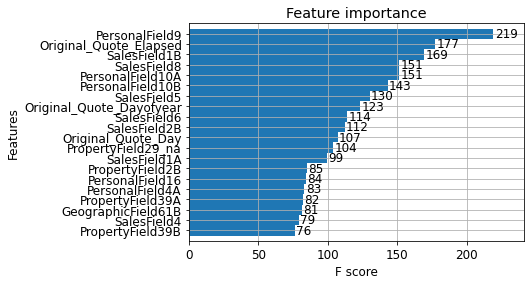

In [ ]:
plot_importance(xgb_model, height=1,max_num_features=20,)

From this most important fields were `SalesField1A`, `PersonalField9`, `Original_Quote_Elapsed`, `PersonalField10A`, `PersonalField10B`, `PropertyField37`

### Doing Ensemble

In [ ]:
avgs = (preds + xgb_preds) / 2

In [ ]:
dl_roc_auc_score

0.9627875189173991

In [ ]:
xg_roc_auc_score

0.9641320936530293

In [ ]:
dlxg_roc_auc_score=roc_auc_score(y_valid, avgs[:,1])
dlxg_roc_auc_score

0.9649714149378368

So we have a slightly better performance with ensembling these two

### Adding Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
tree = RandomForestClassifier(n_estimators=100)

In [ ]:
tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
!pip install rfpimp
from rfpimp import *

In [ ]:
impTree = importances(tree, X_valid, to.valid.ys)

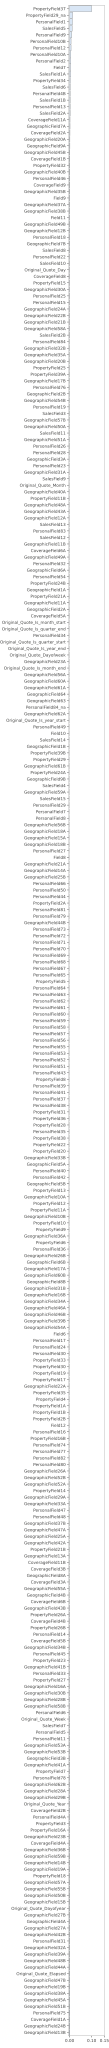

In [ ]:
plot_importances(impTree)

So here the most important are `PropertyField37`, `Field7`,`PersonalField1`, `SalesField5`, `PersonalField9`,`PersonalField2`

In [ ]:
forest_preds = tree.predict_proba(X_valid)

In [ ]:
rf_roc_auc_score=roc_auc_score(y_valid, forest_preds[:,1])
rf_roc_auc_score

0.9555688161095317

In [ ]:
new_avgs =  (preds + xgb_preds + forest_preds) / 3

In [ ]:
dlxgrf_roc_auc_score=roc_auc_score(y_valid, new_avgs[:,1])
dlxgrf_roc_auc_score

0.9642736064955966

So it gets slightly worse when we add Random Forest to the ensemble.

## Bayesian Optimisation

In [ ]:
pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization


In [ ]:
p=learn.get_preds()

In [ ]:
roc_auc_score(y_valid, new_avgs[:,1])

In [ ]:
def fit_with(lr:float, wd:float, dp:float):
    # create a Learner
    config = tabular_config(embed_p=dp, ps=wd)
    learn = tabular_learner(data, layers=[200,100], metrics=roc_auc_binary, config=config)

    # Train for x epochs
    with learn.no_bar():
      learn.fit_one_cycle(3, lr)

    # Save, print, and return the overall accuracy
    preds, targs = learn.get_preds()
    auc_score = roc_auc_score(to_np(targs), to_np(preds[:,1]))

    return auc_score

In [ ]:
def fit_with(lr:float, wd:float, dp:float, n_layers:float, layer_1:float, layer_2:float, layer_3:float):

    print(lr, wd, dp)
    if round(n_layers) == 2:
        layers = [round(layer_1), round(layer_2)]
    elif int(n_layers) == 3:
        layers = [round(layer_1), round(layer_2), round(layer_3)]
    else:
        layers = [round(layer_1)]
    config = tabular_config(embed_p=float(dp),
                          ps=float(wd))
    learn = tabular_learner(dls, layers=layers, metrics=roc_auc_binary, config = config)

    with learn.no_bar() and learn.no_logging():
        learn.fit(5, lr=float(lr))

    preds, targs = learn.get_preds()
    auc_score = roc_auc_score(to_np(targs), to_np(preds[:,1]))

    return auc_score

In [ ]:
hps = {'lr': (1e-05, 1e-01),
      'wd': (4e-4, 0.4),
      'dp': (0.01, 0.5),
       'n_layers': (1,3),
       'layer_1': (50, 200),
       'layer_2': (100, 1000),
       'layer_3': (200, 2000)}


In [ ]:
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = hps, # our hyper parameters to tune
    verbose = 2, # 1 prints out when a maximum is observed, 0 for silent, 2 prints out everything
    random_state=1
)

In [ ]:
%time optim.maximize(n_iter=10)


|   iter    |  target   |    dp     |  layer_1  |  layer_2  |  layer_3  |    lr     | n_layers  |    wd     |
-------------------------------------------------------------------------------------------------------------
0.014684121522803134 0.07482958046651729 0.21434078230426126


|  1        |  0.9608   |  0.2143   |  158.0    |  100.1    |  744.2    |  0.01468  |  1.185    |  0.07483  |
0.06852509784467198 0.3512957275818218 0.1793247562510934


|  2        |  0.9601   |  0.1793   |  109.5    |  584.9    |  954.6    |  0.06853  |  1.409    |  0.3513   |
0.014047289990137426 0.32037752964274446 0.02341992066698382


|  3        |  0.9613   |  0.02342  |  150.6    |  475.6    |  1.206e+0 |  0.01405  |  1.396    |  0.3204   |
0.0894617202837497 0.016006291379859792 0.4844481721025048


|  4        |  0.9588   |  0.4844   |  97.01    |  723.1    |  1.778e+0 |  0.08946  |  1.17     |  0.01601  |
0.0957893741197487 0.27687409473460917 0.09321690558663875


|  5        |  0.9585   |  0.09322  |  181.7    |  188.5    |  958.0    |  0.09579  |  2.066    |  0.2769   |
0.010278165724320144 0.09525641811550664 0.039180893394315415


|  6        |  0.9613   |  0.03918  |  169.8    |  995.0    |  206.4    |  0.01028  |  1.351    |  0.09526  |
0.07156047620301159 0.271888626159136 0.3620644418259379


|  7        |  0.9599   |  0.3621   |  50.52    |  104.8    |  244.5    |  0.07156  |  1.178    |  0.2719   |
0.057910440131609765 0.16129406478624328 0.4828208474809104


|  8        |  0.9594   |  0.4828   |  59.94    |  147.0    |  1.301e+0 |  0.05791  |  2.722    |  0.1613   |
0.006202846991855513 0.20951993783429584 0.23067583083804316


|  9        |  0.9614   |  0.2307   |  51.68    |  999.4    |  298.9    |  0.006203 |  2.818    |  0.2095   |
0.09663960277874367 0.19310815961031857 0.10464053755988437


|  10       |  0.9591   |  0.1046   |  198.2    |  974.5    |  287.6    |  0.09664  |  2.518    |  0.1931   |
0.05567850413856046 0.11500114401999546 0.337315027333027


|  11       |  0.9605   |  0.3373   |  50.13    |  982.2    |  273.1    |  0.05568  |  1.499    |  0.115    |
0.040480764337085445 0.27855633955692755 0.10969012081110371


|  12       |  0.9611   |  0.1097   |  52.69    |  111.7    |  227.7    |  0.04048  |  2.613    |  0.2786   |
0.024931800970252754 0.31830035248339184 0.17955017534933007


|  13       |  0.9617   |  0.1796   |  57.87    |  998.9    |  226.1    |  0.02493  |  1.227    |  0.3183   |
0.0018196385691470996 0.04155229095922732 0.26707532761830727


|  14       |  0.9578   |  0.2671   |  169.2    |  116.2    |  748.3    |  0.00182  |  1.738    |  0.04155  |
0.030785447033720915 0.32171253797353205 0.20217266704192563


|  15       |  0.9624   |  0.2022   |  50.92    |  999.4    |  1.953e+0 |  0.03079  |  2.562    |  0.3217   |
CPU times: user 8min, sys: 8.8 s, total: 8min 8s
Wall time: 7min 59s


In [ ]:
print(optim.max)


{'target': 0.9624438417298263, 'params': {'dp': 0.20217266704192563, 'layer_1': 50.915511579949985, 'layer_2': 999.398009186519, 'layer_3': 1953.2553516382989, 'lr': 0.030785447033720915, 'n_layers': 2.5623176573392747, 'wd': 0.32171253797353205}}


In [ ]:
random_seed = 42 
bs = 4096
val_bs = 512
test_size = 0.3
epochs = 5
lr = 0.03
wd=0.32
layers = [50,1000] #200,150
dropout = [0.001, 0.01]
y_block=CategoryBlock()
emb_dropout=0.2 #0.13
set_seed(42)
roc_auc_binary = RocAucBinary()

In [ ]:
dls = to.dataloaders(bs=bs, val_bs=val_bs, layers=layers, embed_ps=emb_dropout, ps=dropout)

In [ ]:
learn = tabular_learner(dls, metrics=roc_auc_binary)

In [ ]:
learn.fit_one_cycle(6,lr, wd=wd)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.392296,0.325515,0.945146,00:06
1,0.246470,0.194126,0.958200,00:06
2,0.203963,0.180147,0.961087,00:06
3,0.186513,0.175663,0.962731,00:06
4,0.175072,0.173880,0.963781,00:06
5,0.164922,0.174286,0.963852,00:05


In [ ]:
preds, targs = learn.get_preds()

In [ ]:
dl_opt_roc_au_score = roc_auc_score(to_np(targs), to_np(preds[:,1]))
dl_roc_auc_score, dl_opt_roc_au_score


(0.9627875189173991, 0.9638516793393644)

In [ ]:
learn.summary()


TabularModel (Input shape: 4096 x torch.Size([4096, 155]))
Layer (type)         Output Shape         Param #    Trainable 
                     4096 x 5            
Embedding                                 45         True      
Embedding                                 45         True      
____________________________________________________________________________
                     4096 x 3            
Embedding                                 9          True      
Embedding                                 12         True      
____________________________________________________________________________
                     4096 x 4            
Embedding                                 20         True      
____________________________________________________________________________
                     4096 x 3            
Embedding                                 12         True      
____________________________________________________________________________
                 

## Entity Embeddings

Function to embed features, obtained from Fastai forums


In [ ]:
def embed_features(learner, xs):
    xs = xs.copy()
    for i, feature in enumerate(learner.dls.cat_names):
        emb = learner.model.embeds[i]
        new_feat = pd.DataFrame(emb(tensor(xs[feature], dtype=torch.int32).to('cuda:0')), index=xs.index, columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        xs.drop(columns=feature, inplace=True)
        xs = xs.join(new_feat)
    return xs


In [ ]:
emb_xs = embed_features(learn, to.train.xs)


In [ ]:
emb_valid_xs = embed_features(learn, to.valid.xs)


In [ ]:
model = xgb.XGBClassifier(n_estimators = n_estimators, max_depth=max_depth, learning_rate=0.1, subsample=subsample, tree_method='gpu_hist')

In [ ]:
xgb_model_emb=model.fit(emb_xs, y_train)

In [ ]:
xgb_emb_preds = xgb_model_emb.predict_proba(emb_valid_xs)

In [ ]:
xg_emb_roc_auc_score=roc_auc_score(y_valid, xgb_emb_preds[:,1])
xg_roc_auc_score, xg_emb_roc_auc_score

(0.9641320936530293, 0.9637175951487225)